# データを識別してみよう。

## 識別問題
データは通常ベクトルの集合である。
試しに、4個のベクトルを持つデータを作ってみる。

In [ ]:
import numpy as np

x = [[0.0, 0.0],
     [0.0, 1.0],
     [1.0, 0.0],
     [1.0, 1.0]]

データの識別では、データを構成するベクトルはそれぞれラベルを持っている。
次にラベルデータを作ってみる。

In [ ]:
label = np.array([0, 0, 0, 1])

labelの各要素はそれぞれ、ベクトルに対応している。例えば、ベクトル(0, 0)にはラベル0がついている。このベクトルとラベルの対応を機械に覚えさせてみる。これを識別という。


懸命な方は気づいたと思うが、このベクトルとラベルの対応関係はAND演算である。


## ニューラルネットワーク
識別問題を解く方法には様々ある。今後使うだろうニューラルネットワークでこの識別問題を解いてみよう。

作成するニューラルネットワークは入力層、中間層、中間層、出力層の4層で構成する。
はじめの中間層は2個のニューロンで構成され、それぞれのニューロンが2つ入力を持つ。次の中間層も2個のニューロンで構成され、それぞれのニューロンが入力を2つ。出力はソフトマックス関数を用いる。

$z_j = e^{y_j}/\sum e^{y_j}$

ニューラルネットワークを使うにはニューラルネットワーク用のライブラリを使う必要がある。今回はpytorchを使う。pytorchを使い前述のデータを識別するコードを示す。

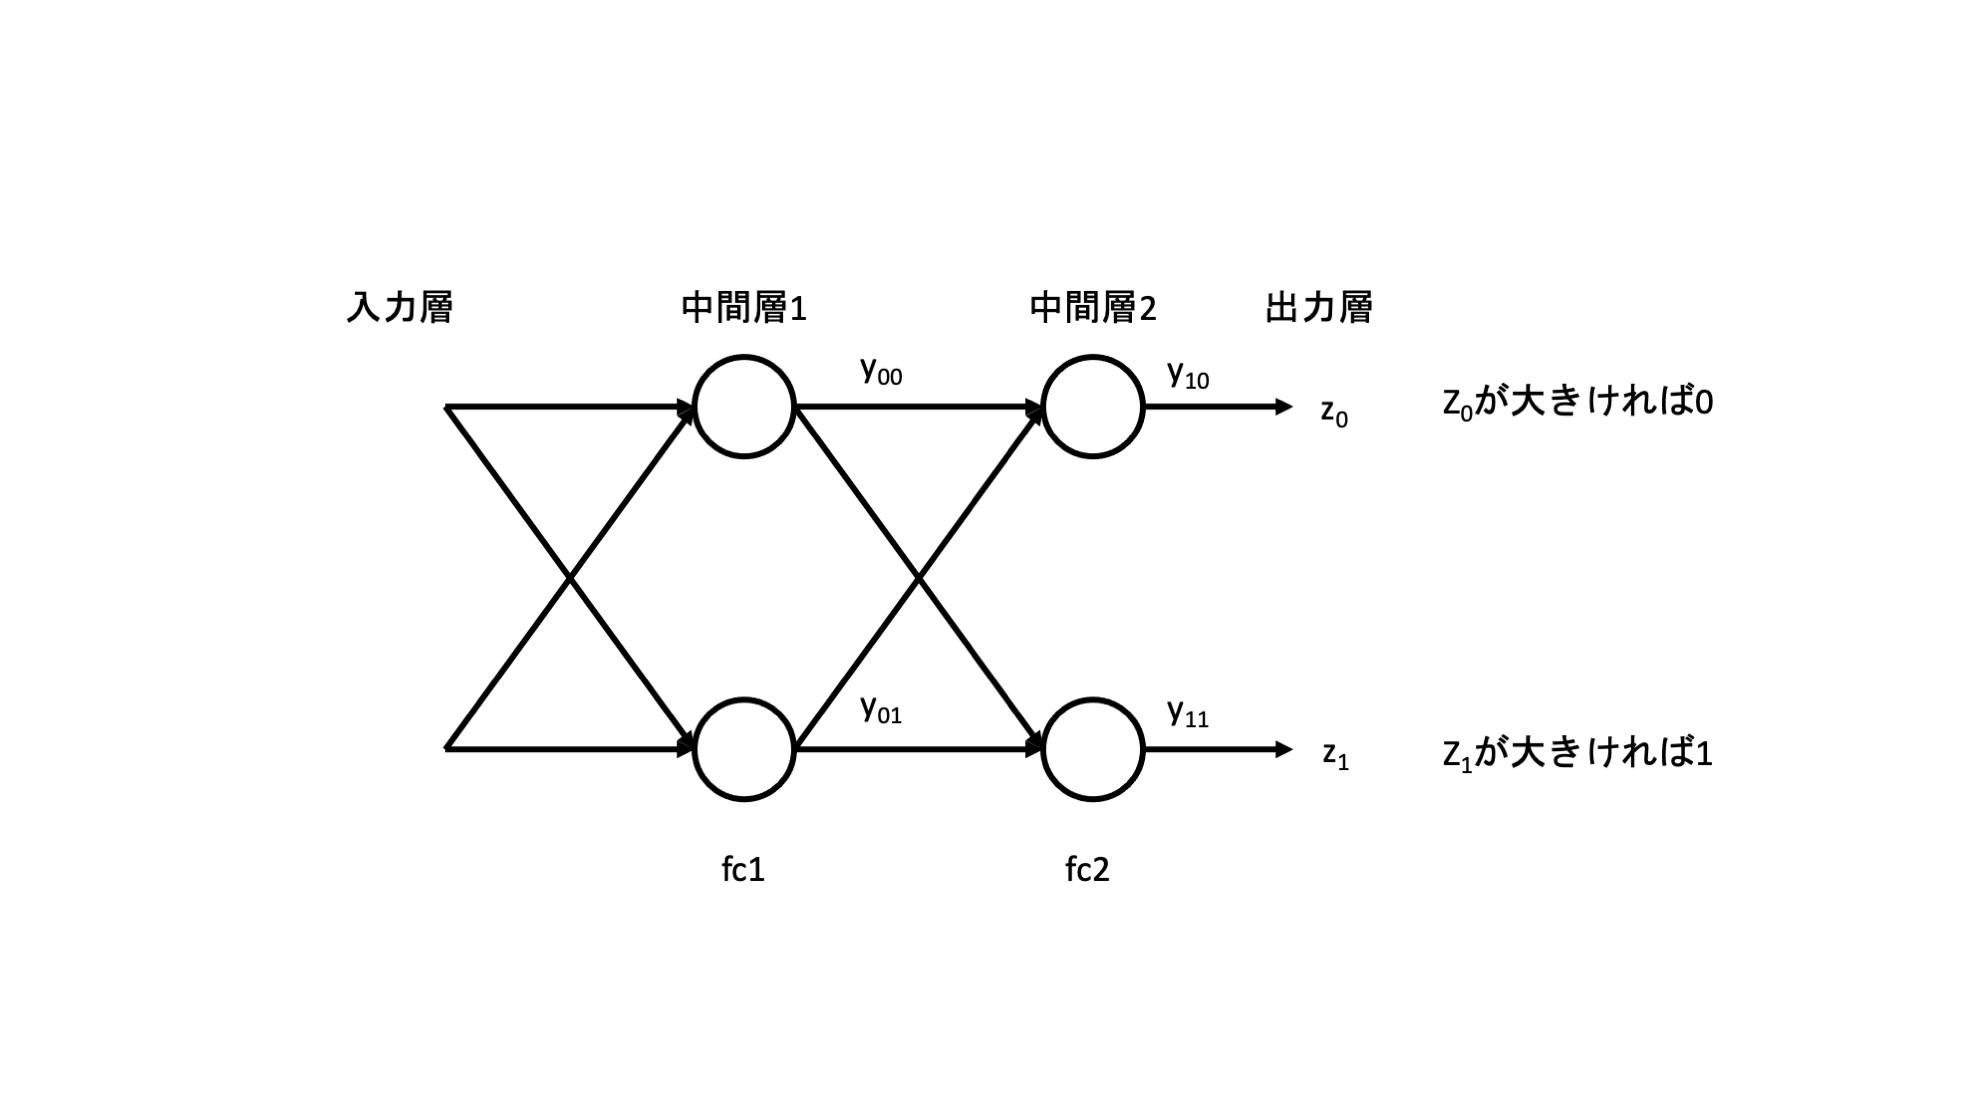

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self):
        #ニューラルネットワークを作る
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear( 2, 2) #中間層1 (入力の数、出力の数)
        self.fc2 = nn.Linear( 2, 2) #中間層2 (入力の数、出力の数)

    def forward(self, input):
        #ニューラルネットワークの計算をする
        h = self.fc1(input) #中間層1の出力の計算
        h = self.fc2(h)     #中間層2の出力の計算
        h = F.log_softmax(h, dim=1) #出力層の出力の計算
        return h

# ネットワークのオブジェクトを生成
model = NeuralNetwork() 
# 最適化手法（学習方法）を設定
optimizer = optim.SGD(model.parameters(),
                      lr=0.5, momentum=0.99, nesterov=True) # 確率的勾配法

epochs = 20 #学習回数
for epoch in range(epochs):
  optimizer.zero_grad()
  X_data = torch.tensor(x) #xをpytorchの形（tensor）に変換
  y_true = torch.tensor(label) #labelをpytorchの形（tensor）に変換

  y_outputs = model(X_data) #ニューラルネットワークの出力を計算
  loss = F.nll_loss(y_outputs, y_true) #出力と正解との差を計算。
  loss.backward()  #逆伝播
  optimizer.step() #学習
  print("学習回数: ", epoch, "誤差: ", loss)

X_data = torch.tensor(x) 
y_outputs = model(X_data)
print(y_outputs)
print(torch.argmax(y_outputs, axis=1))#最大値を持つ配列の要素番号を出力（要素番号=ラベル番号）

学習回数:  0 誤差:  tensor(1.4034, grad_fn=<NllLossBackward0>)
学習回数:  1 誤差:  tensor(0.6850, grad_fn=<NllLossBackward0>)
学習回数:  2 誤差:  tensor(0.5943, grad_fn=<NllLossBackward0>)
学習回数:  3 誤差:  tensor(0.5727, grad_fn=<NllLossBackward0>)
学習回数:  4 誤差:  tensor(0.4867, grad_fn=<NllLossBackward0>)
学習回数:  5 誤差:  tensor(0.5068, grad_fn=<NllLossBackward0>)
学習回数:  6 誤差:  tensor(0.4159, grad_fn=<NllLossBackward0>)
学習回数:  7 誤差:  tensor(0.4415, grad_fn=<NllLossBackward0>)
学習回数:  8 誤差:  tensor(0.7339, grad_fn=<NllLossBackward0>)
学習回数:  9 誤差:  tensor(0.3640, grad_fn=<NllLossBackward0>)
学習回数:  10 誤差:  tensor(0.7450, grad_fn=<NllLossBackward0>)
学習回数:  11 誤差:  tensor(0.4025, grad_fn=<NllLossBackward0>)
学習回数:  12 誤差:  tensor(0.7633, grad_fn=<NllLossBackward0>)
学習回数:  13 誤差:  tensor(0.0996, grad_fn=<NllLossBackward0>)
学習回数:  14 誤差:  tensor(0.0179, grad_fn=<NllLossBackward0>)
学習回数:  15 誤差:  tensor(0.0074, grad_fn=<NllLossBackward0>)
学習回数:  16 誤差:  tensor(0.0028, grad_fn=<NllLossBackward0>)
学習回数:  17 誤差:  tensor(0.